# An introduction to Linear Regression using linear models

## Agenda

- What is a **linear regression**, and how does it work?
- How to train a linear model with **multidimensional** inputs?
- What is a **basis function** and how to use to fit function with different shapes?
- How to apply **regularization** techniques?
- How do I choose **which features to include** in my model?
- How do I **train and interpret** a linear regression model in scikit-learn?


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Types of supervised learning

- **Classification:** Predict a categorical response
- **Regression:** Predict a continuous response

## Simple Linear Regression
Let's suppose to have data as pairs $D = \{(x^{(1)},t^{(1)}), ..., (x^{(N)},t^{(N)}) \}$ where
- $x$ is the input feature
- $t$ is the target output
Our aim is to fit a model, which is a function, with the following shape: $$ y(x)=w_0 +w_1x$$ where $w_0$ is called **bias** and $w_1$ is called **coefficient**, and they are both unknown.
Since the model is **fixed**, our assumption is that a linear model can be represented of the underline distribution in our data. 

To learn the parameters, we need an optimization algorithm and a loss function. Standard loss function is the **squared loss**.

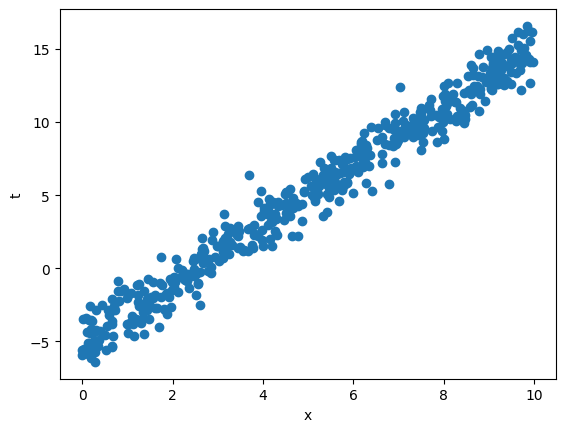

In [2]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(500)
t = 2 * X - 5 + rng.randn(500)
plt.scatter(X, t)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

We split the data in training and test dataset, we will learn the parameters on the training and then we will evaluate on the test set.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, shuffle=True) 

We can use Scikit-Learn's `LinearRegression` estimator to fit this data and construct the best-fit line.

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True, n_jobs=-1)

Now we can fit the model on the training data and learn the parameters.

In [5]:
model.fit(X_train[:, np.newaxis], t_train)

LinearRegression(n_jobs=-1)

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are `coef_` and `intercept_`:

In [6]:
print(f'Model intercept (w0): {model.intercept_}')
print(f'Model slope (w1):     {model.coef_[0]}')

Model intercept (w0): -5.059064297820568
Model slope (w1):     2.020007376740347


We can check the shape of the function that we have fitted.

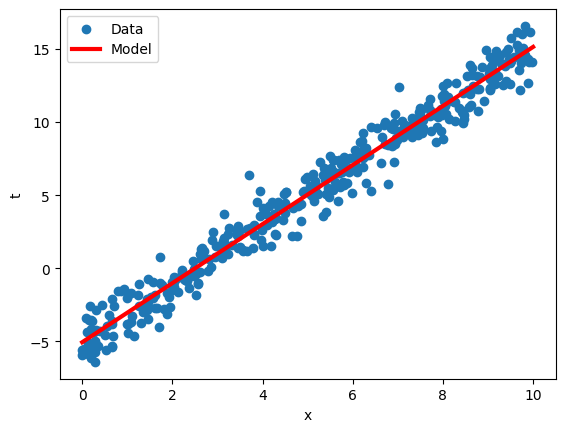

In [7]:
X_train_fit = np.linspace(0, 10, 1000)
t_train_fit = model.predict(X_train_fit[:, np.newaxis])
plt.scatter(X_train, t_train)
plt.plot(X_train_fit, t_train_fit, color='red', linewidth=3)
plt.legend(['Data', 'Model'], loc='best')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

Finally, we can evaluate our model on the test set.

In [8]:
print(f'R2 score on the test set: {model.score(X_test[:, np.newaxis], t_test)}')

R2 score on the test set: 0.9766434014526585


## Linear Regression with Multi-dimensional Inputs 
The `LinearRegression` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form:

$$
y(\textbf{x}) = w_0 +  \sum_{j=1}^{d} w_jx_j = \textbf{w}^T \textbf{x}
$$

Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyperplane to points in higher dimensions.


### Linear Regression with two inputs

In [9]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(250, 2)
t = 0.5 + X[:,0] * rng.rand(250) + X[:,1] * 1.5 * rng.rand(250)

Let's visualize our data in the space.

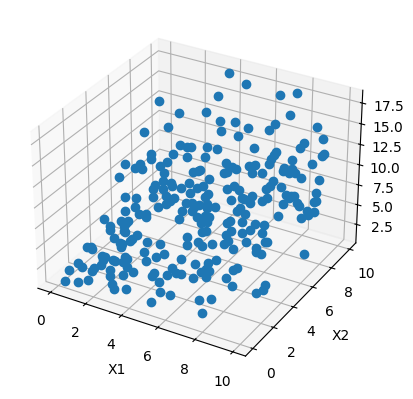

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(X[:,0], X[:,1], t, 'o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('t')
plt.show()

Again, let's split our dataset in training and test.

In [11]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, shuffle=True) 

We can now fit our linear regression model.

In [12]:
model = LinearRegression(fit_intercept=True, n_jobs=-1)
model.fit(X_train, t_train)

LinearRegression(n_jobs=-1)

In [13]:
print(f'Model intercept (w0): {model.intercept_}')
print(f'Model slope (w1, w2): {model.coef_}')

Model intercept (w0): 0.8813991940974653
Model slope (w1, w2): [0.4779147  0.65148178]


Let's define the equation of the fitted regression plane.

In [14]:
plane = X_train[:,0] * model.coef_[0] + X_train[:,1] * model.coef_[1] + model.intercept_

Let's visualize the fitted regression plane with respect to the training data.

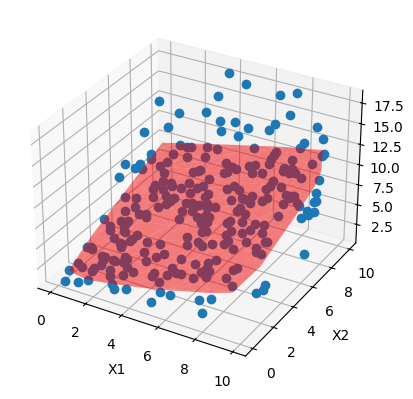

In [15]:
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(X_train[:,0], X_train[:,1], plane, color='red', alpha=0.5)
ax.plot3D(X[:,0], X[:,1], t, 'o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('t')
plt.show()

Finally, let's evaluate on the test set.

In [48]:
print(f'R2 score on the test set: {model.score(X_test, t_test)}')

R2 score on the test set: 0.48291935006930653
